In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn import mixture
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt

In [0]:
N_HIDDEN = 128
N_NOISE = 512
NUM_BATCH = 512
NUM_GRADS = 5000
CRITERION =nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

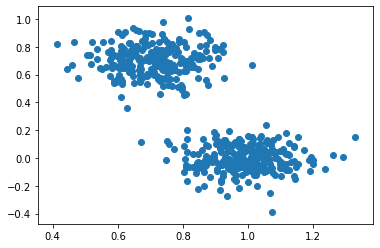

In [50]:
#sample NUM_BATCH samples from 2d gaussian mixture distribution
def get_data(mu1 = [2**(-1/2), 2**(-1/2)], mu2=[1,0], sigma= 0.01, plot=False):
  cov = np.identity(2)*sigma
  mu1 = mu1
  mu2 = mu2

  data = []
  d1 = multivariate_normal(mu1, cov, int(NUM_BATCH/2))
  d2 = multivariate_normal(mu2, cov, int(NUM_BATCH/2))
  data = np.concatenate((d1, d2), axis=0)
  np.random.shuffle(data)

  if plot:
    plt.scatter(data[:,0],data[:,1])

  return data


#test
data = get_data(plot=True)

In [0]:

class Generator(nn.Module):
    def __init__(self, input_size=N_NOISE, output_size=2):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, N_HIDDEN)
        self.fc2 = nn.Linear(self.fc1.out_features, N_HIDDEN)
        self.fc3 = nn.Linear(self.fc2.out_features, N_HIDDEN)
        self.fc4 = nn.Linear(self.fc3.out_features, output_size)

    #latent variable input
    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, input_size=2, output_size=1):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, N_HIDDEN)
        self.fc2 = nn.Linear(self.fc1.out_features, N_HIDDEN)
        self.fc3 = nn.Linear(self.fc2.out_features, N_HIDDEN)
        self.fc4 = nn.Linear(self.fc3.out_features, output_size)

    #[x1,x2] input
    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x


In [0]:
def D_train(x):

    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, 2), torch.ones(NUM_BATCH, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    Z = torch.randn(NUM_BATCH, N_NOISE).to(device)
    x_fake, y_fake = G(z), torch.zeros(NUM_BATCH, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

    
def G_train(x):
    G.zero_grad()

    z = torch.randn(NUM_BATCH, N_NOISE).to(device)
    y = torch.ones(NUM_BATCH, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [64]:
G = Generator().to(device)
D = Discriminator().to(device)

n_epoch = 200

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    train_loader = torch.utils.data.DataLoader(dataset=get_data(), batch_size=NUM_BATCH, shuffle=True)
    for batch_idx, (x) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

RuntimeError: ignored